<a href="https://colab.research.google.com/github/fils/csdco-rgb-notebook/blob/main/csdco_rgb_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSDCO Demo 1


### Installs

In [ ]:
%%capture
#@title
!apt-get install libproj-dev proj-data proj-bin -qq
!apt-get install libgeos-dev -qq
!pip install -q cython
!pip install -q cartopy
!pip install -q SPARQLWrapper
!pip install -q rdflib==4.2.2
!pip install -q geopandas
!pip install -q contextily==1.0rc2
!pip install -q rdflib-jsonld==0.5.0

### Imports

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely

dbsparql = "http://dbpedia.org/sparql"
ocd = "http://graph.opencoredata.org/blazegraph/namespace/ocd/sparql"

### Helping function(s)
The following block is a SPARQL to Pandas feature.  You may need to run it to load the function per standard notebook actions.

In [ ]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

### Set PD frame options

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


## Search in the notebook

This would be hidden in a form and the query would not be open.  However, people could start to play with the raw search too as they get comfortable with the graph

In [ ]:
rq1 = """
prefix schema: <https://schema.org/> 
SELECT DISTINCT ?name ?lit ?description ?type ?score ?s 
WHERE 
{   
  ?lit bds:search " RGB Image Data PLJV" .   
  ?lit bds:matchAllTerms "false" .   
  ?lit bds:relevance ?score .   
  ?s ?p ?lit .   
  ?s schema:name ?name .   
  ?s schema:description ?description .    
  ?s rdf:type ?type . 
} 
ORDER BY DESC(?score) 
"""

dfrq1 = get_sparql_dataframe(ocd, rq1)

Take a look at the search results...   need to improve this a bit.  Also, people can search o the web site and simply pull file references from there too.

In [ ]:
dfrq1.head()

,name,lit,description,type,score,s
0,PLJV-CA1012-2A-4S-1.csv,Digital object of type RGB Image Data named PLJV-CA1012-2A-4S-1.csv for CSDCO project PLJV,Digital object of type RGB Image Data named PLJV-CA1012-2A-4S-1.csv for CSDCO project PLJV,http://www.schema.org/DigitalDocument,0.546875,https://opencoredata.org/id/csdco/do/05c1397d8e672e64b09d34d17f912607df71163a103327c6c1eb05f10ac7730a
1,PLJV-LE312-2A-2S-1.csv,Digital object of type RGB Image Data named PLJV-LE312-2A-2S-1.csv for CSDCO project PLJV,Digital object of type RGB Image Data named PLJV-LE312-2A-2S-1.csv for CSDCO project PLJV,http://www.schema.org/DigitalDocument,0.546875,https://opencoredata.org/id/csdco/do/11956476e3c27d20ec850d73103da73d2b327b6a9cff7f9b9fae99137569d2b9
2,PLJV-CA712-1A-3S-1.csv,Digital object of type RGB Image Data named PLJV-CA712-1A-3S-1.csv for CSDCO project PLJV,Digital object of type RGB Image Data named PLJV-CA712-1A-3S-1.csv for CSDCO project PLJV,http://www.schema.org/DigitalDocument,0.546875,https://opencoredata.org/id/csdco/do/1684cecaf22ec9ca2751f312afcc839a72b2f084176662f40f14000658d6878b
3,PLJV-LE1312-1A-6S-1.csv,Digital object of type RGB Image Data named PLJV-LE1312-1A-6S-1.csv for CSDCO project PLJV,Digital object of type RGB Image Data named PLJV-LE1312-1A-6S-1.csv for CSDCO project PLJV,http://www.schema.org/DigitalDocument,0.546875,https://opencoredata.org/id/csdco/do/19b72a21b5e8a887b70d726f1a1073f9e8bf8f2518484f39560488eeb2637997
4,PLJV-LE1212-1A-2S-1.csv,Digital object of type RGB Image Data named PLJV-LE1212-1A-2S-1.csv for CSDCO project PLJV,Digital object of type RGB Image Data named PLJV-LE1212-1A-2S-1.csv for CSDCO project PLJV,http://www.schema.org/DigitalDocument,0.546875,https://opencoredata.org/id/csdco/do/1e7152be95080dda776f5df3ee81266aaad441d0c9f46dce1c6039ece548234d


## Load a CSDCO / Open Core object into a dataframe

Let's sat we did a search and found some files we want to try.   We can load CSV, images, and other various formats.  CSV is easy though, so lets start there.  We will load the file into a Pandas data frame.  You could make custom loaders for known types too.  This RGB example requires me to skip header lines for instance. 


Our CSV has some header info..   we will need to skip some lines

In [ ]:
file = "https://opencoredata.org/id/csdco/do/1a4b80ab31515d8bb6e4405ff8c7016d767a139912bd2503457be03f78a3ca7e"

Let's look at the top of our files to check it...

In [ ]:
from urllib.request import urlopen
data = urlopen(file).read().decode('utf-8')

lines = data.split('\n')
for i in range(10):
  print(lines[i])

Looks like we need to skip a few lines to get to our data. 

In [ ]:
dff1 = pd.read_csv(file, skiprows=8)  

In [ ]:
dff1.info()  # Take a look at the line count and column types

In [ ]:
dff1.head()  # just a quick check to see if we got the right stuff.  

We can so a quick plot then

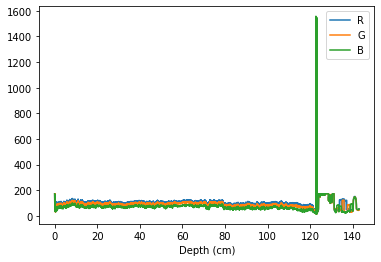

In [ ]:
dff1.plot(x='Depth (cm)', y=['R', 'G', 'B'])

We can slice off the end to see what is up with the data at the end.   Looks like the spike is some sort of instrument event the researcher might need to clean up before using the file?

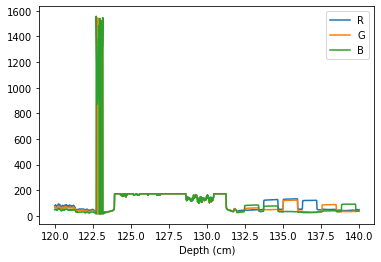

In [ ]:
dff1.iloc[12000:14000].plot(x='Depth (cm)', y=['R', 'G', 'B'])
